# Word2Vec then RNN

## Load data

In [1]:
import pandas as pd
from os import path

importDirectory = "../state/data/preprocessed-train-test/"

train, test, data, contestTest = map(
    lambda filename: pd.read_csv(path.join(importDirectory, filename)), 
    ["train.csv", "test.csv", "all.csv", "contest-test.csv"])

In [2]:
print("train: {}, test: {}, all: {}, contestTest: {}".format(
    train.shape, test.shape, data.shape, contestTest.shape))

train: (127656, 8), test: (31915, 8), all: (159571, 8), contestTest: (153164, 2)


In [3]:
def splitSentences(dataset):
    return (dataset.comment_text
    .str.replace("[^A-Za-z\s]", "")
    .str.lower()
    .str.split())

In [4]:
%%time
splitTrain = splitSentences(train)
splitTest = splitSentences(test)

CPU times: user 3 s, sys: 172 ms, total: 3.18 s
Wall time: 3.18 s


## Sentense lengths

In [5]:
sentenceLengths = splitTrain.apply(len)
sentenceLengths.describe()

count    127656.000000
mean         65.470616
std          97.108352
min           0.000000
25%          16.000000
50%          35.000000
75%          73.000000
max        1403.000000
Name: comment_text, dtype: float64

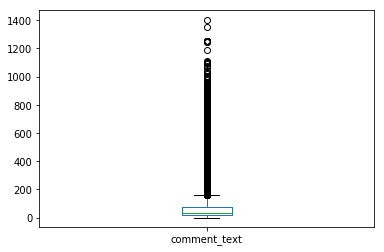

In [6]:
import matplotlib.pyplot as plt

sentenceLengths.plot.box()
plt.show()

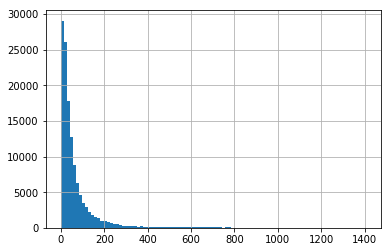

In [7]:
sentenceLengths.hist(bins=100)
plt.show()

In [8]:
maxSeqLength = 250

## Load Word2Vec dictionary

In [9]:
%%time
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format("../state/external-models/glove.6B/w2v.glove.6B.50.txt")

CPU times: user 24.8 s, sys: 508 ms, total: 25.3 s
Wall time: 25.4 s


In [10]:
numDimensions = 50

In [11]:
%%time
vocabulary = set(model.vocab.keys())

CPU times: user 52 ms, sys: 4 ms, total: 56 ms
Wall time: 54.8 ms


## Transform sentences to sequences of vectors

In [12]:
%%time
import numpy as np

# If possible, vectorize this transformation
def wordsToVector(words):
    allowedWords = [word for word in words if word in vocabulary]
    leftWords = allowedWords if allowedWords else ["hello"]
    
    return np.array(list(map(model.word_vec, leftWords)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.9 µs


In [13]:
%%time
w2vTrainFeatures = splitTrain.apply(wordsToVector)

CPU times: user 17.5 s, sys: 452 ms, total: 17.9 s
Wall time: 17.9 s


In [14]:
%%time
w2vTestFeatures = splitTest.apply(wordsToVector)

CPU times: user 4.56 s, sys: 164 ms, total: 4.72 s
Wall time: 4.72 s


## Oversample

In [15]:
def oversample(dataset, features, label): 
    multiples = int(dataset[dataset[label] == 0].shape[0] / dataset[dataset[label] == 1].shape[0])
    
    datasetPositive = dataset[dataset[label] == 1]
    featuresPositive = features[datasetPositive.index.tolist()]
    
    datasetOversampled = pd.concat([dataset] + multiples * [datasetPositive]).reset_index() 
    featuresOversampled = pd.concat([features] + multiples * [featuresPositive]).reset_index().comment_text
    
    return datasetOversampled, featuresOversampled

In [16]:
trainOversampled, w2vTrainFeaturesOversampled = oversample(train, w2vTrainFeatures, "toxic")

## Helper function to get batches

In [17]:
# Is padding the words till position 250 with 0s the right approach?
def padWithZeros(array):
    fullArray = np.zeros([maxSeqLength, numDimensions])
    fullArray[:min(array.shape[0], maxSeqLength), :] = array[:min(array.shape[0], maxSeqLength), :]
    return fullArray

In [18]:
# always remember to reset the seed before using getTrainBatch
np.random.seed(4324)

# Check if vectorizing this one can improve performance
def getBatch(dataset, features, size):
    indices = np.random.randint(0, len(features), size)
    
    features = np.array(features[indices].apply(padWithZeros).tolist())
    labels = (np
        .array(dataset.toxic[indices]
        .apply(
            lambda label: np.array([0., 1.]) if label == 0 else np.array([1., 0.])).tolist()))
    return features, labels

def getTrainBatch(size):
    return getBatch(trainOversampled, w2vTrainFeaturesOversampled, size)

## LMST with keras

In [29]:
def getFeaturesAndLabels(dataset, features, size):
    features = np.array(features[:size].apply(padWithZeros).tolist())
    labels = np.array(
        dataset
            .toxic[:size]
            .apply(
                lambda label: np.array([0., 1.]) if label == 0 else np.array([1., 0.])).tolist())
    
    return features, labels

In [30]:
%%time
# Beware, this will use ~40 GB of RAM
trainFeatures, trainLabels = getFeaturesAndLabels(trainOversampled, w2vTrainFeaturesOversampled, trainOversampled.shape[0])

CPU times: user 328 ms, sys: 104 ms, total: 432 ms
Wall time: 432 ms


In [31]:
lstmUnits = 64
numClasses = 2
batchSize = 512

In [32]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17596088703314465664
]


In [36]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [34]:
tf.set_random_seed(43245)
np.random.seed(453252)

In [37]:
model = Sequential()

model.add(LSTM(lstmUnits, dropout=0.2, recurrent_dropout=0.2, input_shape=trainFeatures.shape[1:]))
model.add(Dense(2, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 29,570
Trainable params: 29,570
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
%%time
model.fit(trainFeatures, trainLabels, nb_epoch=5, batch_size=batchSize, verbose=2)

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/5
 - 48s - loss: 0.3113 - acc: 0.9062
Epoch 2/5
 - 46s - loss: 0.2956 - acc: 0.9070
Epoch 3/5
 - 53s - loss: 0.2990 - acc: 0.9017
Epoch 4/5
 - 54s - loss: 0.3160 - acc: 0.9032
Epoch 5/5
 - 55s - loss: 0.3153 - acc: 0.9032
CPU times: user 13min 9s, sys: 45.5 s, total: 13min 54s
Wall time: 4min 15s


## Defining the RNN

In [ ]:
lstmUnits = 64
numClasses = 2
batchSize = 2048

In [ ]:
import tensorflow as tf

tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses], name="labels")
data = tf.placeholder(tf.float32, [batchSize, maxSeqLength, numDimensions], name="data")

lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCellWithDropout = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCellWithDropout, data, dtype=tf.float32)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

auc = 1 - tf.metrics.auc(tf.argmax(labels, 1), tf.clip_by_value(prediction[:, 0], 0, 1), name="auc")[1]
acc = tf.metrics.accuracy(tf.argmax(labels, 1), tf.argmax(prediction, 1), name="accuracy")[1]

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels), name="loss")
optimizer = tf.train.AdamOptimizer().minimize(loss)

## Persist for tensorboard

In [ ]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Area_under_roc', auc)
tf.summary.scalar("Accuracy", acc)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"

## Training the model

In [ ]:
%%time
saver = tf.train.Saver()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
np.random.seed(4324)
tf.set_random_seed(43245)

epochs = 10
samplesPerEpoch = int(trainOversampled.shape[0] / batchSize)

with tf.Session() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter(logdir, sess.graph)
    
    for epoch in range(epochs):
        print("Epoch #{}".format(epoch))
        for i in range(samplesPerEpoch):
            nextBatch, nextBatchLabels = getTrainBatch(batchSize)
            
            sess.run(optimizer, {data: nextBatch, labels: nextBatchLabels})

            #Save the network every 1,000 training iterations
            iteration = epoch * samplesPerEpoch + i
            
            if (iteration % 1000 == 0 and iteration != 0):
                save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=iteration)
                print("saved to %s" % save_path)
                
            #Write summary to Tensorboard
            if (iteration % 100 == 0 and iteration != 0):
                print(f"Loss: {sess.run(loss, {data: nextBatch, labels: nextBatchLabels})}")
                print(f"Acc: {sess.run(acc, {data: nextBatch, labels: nextBatchLabels})}")
                print(f"Auc: {sess.run(auc, {data: nextBatch, labels: nextBatchLabels})}")
                summary = sess.run(merged, {data: nextBatch, labels: nextBatchLabels})
                writer.add_summary(summary, iteration)
    writer.close()

In [ ]:
def getTestBatch(size):
    return getBatch(test, w2vTestFeatures, size)

In [ ]:
%%time
saver = tf.train.Saver()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

preds = []

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, "./models/pretrained_lstm.ckpt-74000")
    
    for i in range(int(test.shape[0]/batchSize)):
        if i % 100 == 0:
            print(i)
        nextBatch, nextBatchLabels = getTestBatch(batchSize)

        preds.append((sess.run(prediction, {data: nextBatch}), nextBatchLabels[:, 0]))

In [ ]:
prd, labs = zip(*preds)

In [ ]:
prdProbVec = np.concatenate(prd)

In [ ]:
prdVec = np.where(prdProbVec[:, 0] > 0.5, 1, 0)

In [ ]:
labsVec = np.concatenate(labs, axis=0)

In [ ]:
%%time
saver = tf.train.Saver()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

logloss = []
accuracy = []
auroc = []

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, "./models/pretrained_lstm.ckpt-74000")
    
    for i in range(int(test.shape[0]/batchSize)):
        if i % 100 == 0:
            print(i)
        nextBatch, nextBatchLabels = getTestBatch(batchSize)
        logloss.append(sess.run(loss, {data: nextBatch, labels: nextBatchLabels}))
        accuracy.append(sess.run(acc, {data: nextBatch, labels: nextBatchLabels}))
        auroc.append(sess.run(auc, {data: nextBatch, labels: nextBatchLabels}))

In [ ]:
def lavg(l):
    return sum(l) / len(l)

In [ ]:
print(f"Loss: {lavg(logloss)}")
print(f"Accuracy: {lavg(accuracy)}")
print(f"AUC: {lavg(auroc)}")

In [ ]:
from evaluate_predictions import evaluatePredictions

evaluatePredictions(pd.Series(labsVec), prdVec, 1 - prdProbVec)